In [1]:
# imports for analysis
import numpy as np
from scipy.io import loadmat
from collections import defaultdict
from nilearn.glm.first_level import FirstLevelModel

# imports for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imports for data loading, processing and analysis
from utils.io import get_args, load_data
from utils.preprocessing import set_get_timeseries, build_sub_run_df, convert_df_to_desMat, add_VTC_get_breaks, exclude_irrelevant_VTC_TRs
from utils.nilearn_analysis import fit_edge_flm

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# Set rng for replication
np.random.seed(2022)

In [3]:
# ARGUMENTS
OVERWRITE = False # whether to fit new betas
NTPS_FIR = 31 # how many timepoints to investigate using FIR
RUN_IDX = 0  # which run to use, 0 indexed
args = get_args() # sets many default arguments, can be changed by passing in a list of arguments

ridx, cidx = np.tril_indices(args.nROI, -1)
get_timeseries = set_get_timeseries(args, ridx, cidx)  # set the type of timeseries to use, ROI or edge

timeseries_data, sub_file_map, sublist, ntr_tossed = load_data(args)

In [4]:
if OVERWRITE:
    # PREPROCESS BEHAV DATA, MAKE DESIGN MATRICES
    des_mat_dict = defaultdict(list)
    fitable_timeseries = defaultdict(list)
    for sidx, sub in enumerate(sublist):
        
        sub_files = sub_file_map[sidx]

        for runidx, sub_file in enumerate(sub_files[:2]): # ONLY TAKING THE FIRST OR SECOND
            if runidx==RUN_IDX:
                sub_trs = np.arange(timeseries_data[sidx][runidx].shape[0])*args.t_r
                
                sub_run_df = build_sub_run_df(loadmat(sub_file), ntr_tossed, args)
                
                sub_run_df, (break_onsets, break_offsets, break_durations) = add_VTC_get_breaks(sub_run_df, args)

                sub_run_desmat = convert_df_to_desMat(
                        sub_run_df,
                        sub_trs,
                        model=args.model,
                        VTC_shift = args.VTC_shift,
                        break_durations=break_durations,
                        hrf_model='fir',
                        fir_delays = np.arange(NTPS_FIR)
                    )
                
                    
                curr_timeseries = get_timeseries(timeseries_data[sidx][runidx])
                    
                sub_run_desmat, curr_timeseries = exclude_irrelevant_VTC_TRs(sub_run_desmat, curr_timeseries, args, break_onsets, break_offsets)

                des_mat_dict[sub].append(sub_run_desmat)    
                fitable_timeseries[sub].append(curr_timeseries)

    # FIR ESTIMATES
    nsites = args.nROI if args.use_rois else len(ridx)
    betas = np.full((len(des_mat_dict.keys()), nsites, NTPS_FIR), np.nan)

    for sidx, sub in enumerate(des_mat_dict.keys()):
        if len(des_mat_dict[sub]): # sub17, VTC_trialTypes model doesn't have any full design matrices
            fitted_flm = fit_edge_flm(
                FirstLevelModel(t_r=args.t_r, signal_scaling=args.signal_scaling, noise_model=args.glm_noise_model),
                run_Ys=fitable_timeseries[sub],
                design_matrices=des_mat_dict[sub],
            )
            
            labels = fitted_flm.labels_[0]
            regression_result = fitted_flm.results_[0]


            for delay in range(NTPS_FIR):
                con_val = fitted_flm.design_matrices_[0].columns.isin([f'probe_success_delay_{delay}', f'probe_fail_delay_{delay}'])

                for label_ in regression_result:
                    label_mask = labels == label_

                    betas[sidx, label_mask, delay] = np.dot(con_val, regression_result[label_].theta)
            
    np.save(f'results/betas/edges_run{RUN_IDX+1}', betas)
else:
    betas = np.load(f'results/betas/edges_run{RUN_IDX+1}.npy')

In [5]:
betas_means = betas.mean(0)

# Using k-means and elbowing to find the right number of clusters

In [6]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan', 'magenta']

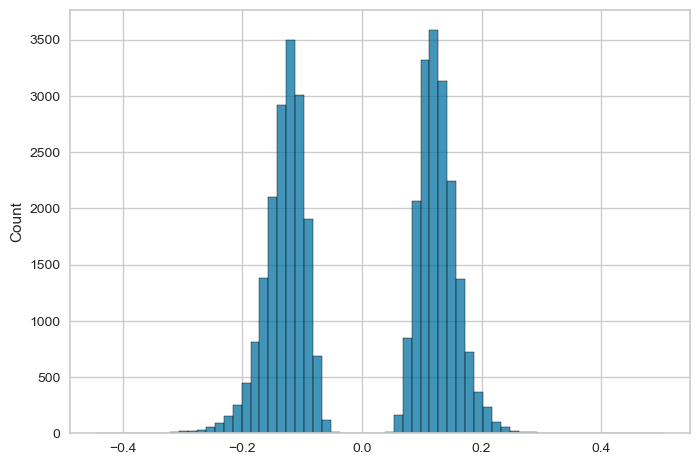

In [7]:
# flipping signs based on largest value across the timeseries, for each edge

lowest_vals = betas_means.min(1)
highest_vals = betas_means.max(1)
largest_vals = np.where(np.abs(lowest_vals)>np.abs(highest_vals), lowest_vals, highest_vals)
_ = sns.histplot(largest_vals)
plt.show()
plt.close()

betas_magSigned = betas_means / np.sign(largest_vals)[:, np.newaxis]

In [8]:
# Set rng for replication
np.random.seed(2022)

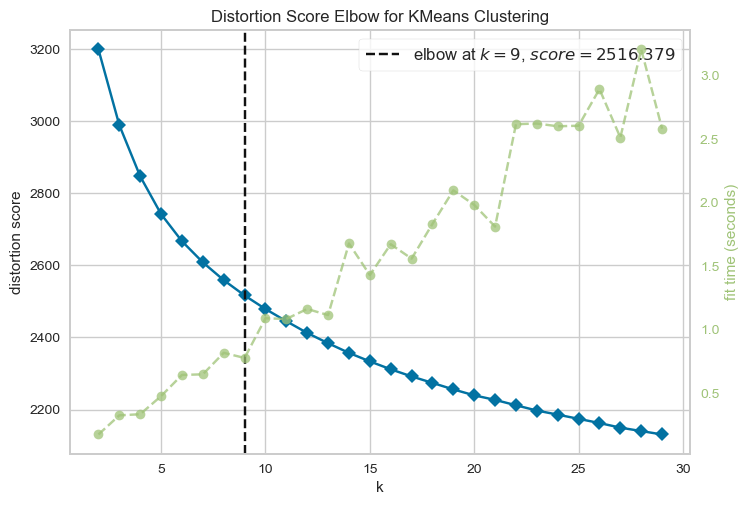

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(betas_magSigned)        # Fit data to visualizer
visualizer.show() 

In [10]:
n_clusters = visualizer.elbow_value_

In [11]:
model = KMeans(n_clusters=n_clusters)
model.fit(betas_magSigned)

KMeans(n_clusters=9)

In [12]:
yhat = model.predict(betas_magSigned)
clusters = sorted(np.unique(yhat))

In [13]:
np.save(f'results/betas/clustered_edges_run{RUN_IDX+1}', yhat)

In [14]:
cluster_sizes = np.full(len(clusters), np.nan)
for cluster in clusters:
    cluster_sizes[cluster] = np.sum(yhat == cluster)

In [15]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.nanmean(a,0)
    std = np.std(a,0)
    upper,lower = mean + std, mean - std
    return mean, upper, lower

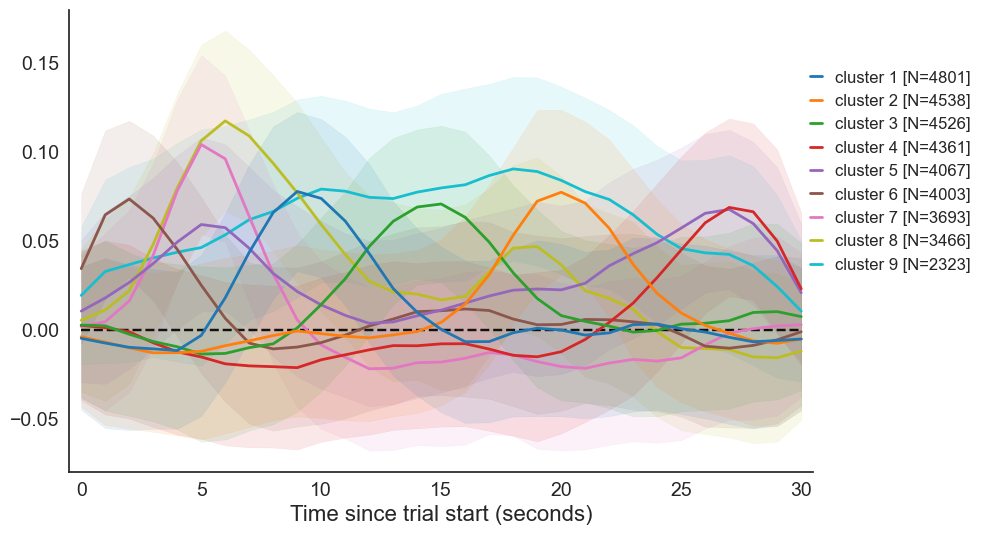

In [23]:
fig = plt.figure(figsize=(12,6))
plt.style.use("seaborn-v0_8-white")

plt.plot(np.zeros(NTPS_FIR), color='k', linestyle='--')

for cid, cluster in enumerate(np.argsort(cluster_sizes)):
    cid = n_clusters-cid #
    med, upper, lower = get_plot_line(betas_magSigned[yhat == cluster, :])
    
    line, = plt.plot(med, color=colors[cid-1], linewidth=2)
    line.set_label(f'cluster {cid} [N={sum(yhat==cluster)}]')
    plt.fill_between(np.arange(NTPS_FIR),upper,lower, color=colors[cid-1],alpha=.1)
    
plt.xlabel('Time since trial start (seconds)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-.5, 30.5])
ax=plt.gca()
ax.spines[['right', 'top']].set_visible(False)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(.975, 0.65), fontsize=12, handlelength=.75)
plt.savefig(f"results/figures/FIR_estimates_edges_RUN{RUN_IDX+1}.svg", bbox_inches="tight", dpi=300, transparent=True)
plt.show()
plt.close()